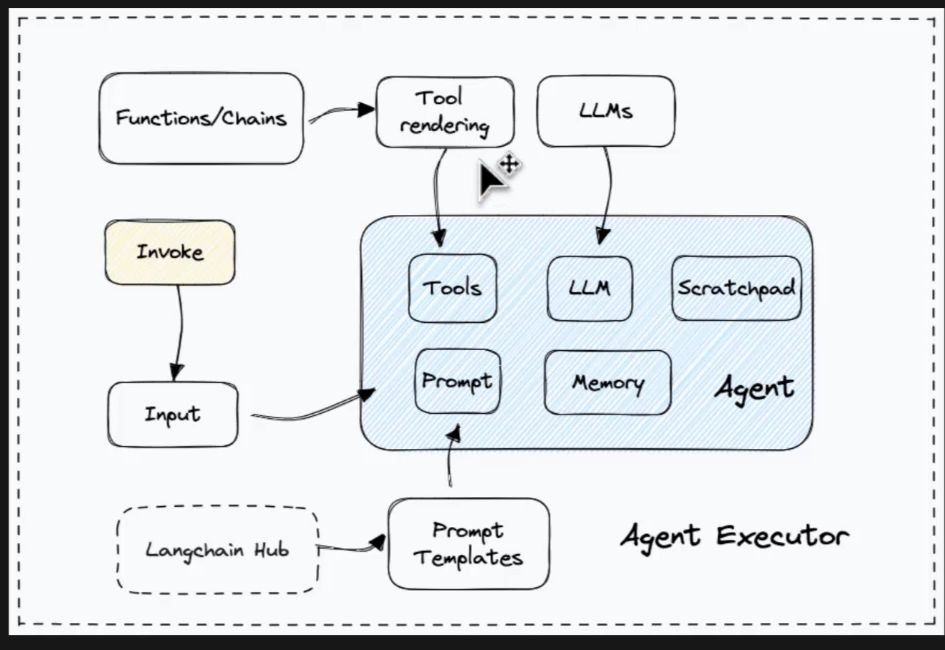

## Agents
### Your Personal Health Expert 

- Agents are systems that use an LLM as a reasoning engine to determine which actions to take and what the inputs to those actions should be.
- The results of those actions can then be fed back into the agent and it determines whether more actions are needed, or whether it is okay to finish.

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_ollama import ChatOllama 
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough 
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool

In [3]:
llm = ChatOllama(model='llama3.2:3b', base_url='http://localhost:11434')
llm.invoke('hi')

AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'model': 'llama3.2:3b', 'created_at': '2024-11-25T07:23:30.1731864Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 2596476300, 'load_duration': 2307682000, 'prompt_eval_count': 26, 'prompt_eval_duration': 154000000, 'eval_count': 8, 'eval_duration': 132000000}, id='run-87360217-4e70-40bf-b998-55894ac2da6f-0', usage_metadata={'input_tokens': 26, 'output_tokens': 8, 'total_tokens': 34})

### Define Tools
#### 1. Tavily

In [4]:
from langchain_community.tools import TavilySearchResults

In [5]:
@tool
def search(query: str) -> str:
    """
    Search the web for realtime and latest information.
    for examples, news, stock market, weather updates etc.
    
    Args:
    query: The search query
    """
    
    search = TavilySearchResults(
        max_results=5,
        search_depth="advanced",
        include_answer=True,
        include_raw_content=True,
    )
    response = search.invoke(query)
    return response

#### 2. Health Supplements Retriever

In [6]:
from langchain_ollama import OllamaEmbeddings

import faiss
from langchain_community.vectorstores import FAISS 
from langchain_community.docstore.in_memory import InMemoryDocstore

In [7]:
embeddings = OllamaEmbeddings(model='nomic-embed-text', base_url='http://localhost:11434')

db_name = "../13 - Vector Stores and Retrievals/health_supplements"

vector_store = FAISS.load_local(db_name, embeddings, allow_dangerous_deserialization=True)

retriever = vector_store.as_retriever(search_type = 'similarity', 
                                      search_kwargs = {'k': 3})

In [8]:
@tool
def health_supplements(query: str) -> str:
    """Search for information about Health Supplements.
    For any questions about Health and Gym Supplements, you must use this tool!,

    Args:
        query: The search query.
    """
    response = retriever.invoke(query)
    return response

In [9]:
health_supplements.invoke("what is the best supplement for muscle gain?")

[Document(metadata={'source': './rag-dataset\\gym supplements\\1. Analysis of Actual Fitness Supplement.pdf', 'file_path': './rag-dataset\\gym supplements\\1. Analysis of Actual Fitness Supplement.pdf', 'page': 0, 'total_pages': 15, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'iLovePDF', 'creationDate': '', 'modDate': 'D:20241021113850Z', 'trapped': ''}, page_content='acids than traditional protein sources. Its numerous benefits have made it a popular choice\nfor snacks and drinks among consumers [3]. Another widely embraced supplement is\ncaffeine, which is found in many sports and food supplements. Caffeine reduces perceived\neffort, minimizes fatigue and pain, and proves to be effective for endurance and high-\nintensity activities, which is the choice of consumers [4].\nCreatine monohydrate is another well-known supplement used to gain muscle mass\nand support performance and recovery. It is known not to increase fat mas

### Agent Creation

 - The agent is responsible for taking in input and deciding what actions to take
 - the Agent does not execute those actions - that is done by the AgentExecutor
 - `create_tool_calling_agent` will call `.bind_tools` for us under the hood.

In [14]:
from langchain import hub
from langchain.agents import create_tool_calling_agent ,AgentExecutor

In [12]:
prompt = hub.pull("hwchase17/openai-functions-agent")

In [13]:
prompt.messages

[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are a helpful assistant'), additional_kwargs={}),
 MessagesPlaceholder(variable_name='chat_history', optional=True),
 HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, template='{input}'), additional_kwargs={}),
 MessagesPlaceholder(variable_name='agent_scratchpad')]

In [15]:
tools = [search, health_supplements]

agent = create_tool_calling_agent(llm=llm, tools=tools, prompt=prompt)

In [16]:
agent

RunnableAssign(mapper={
  agent_scratchpad: RunnableLambda(lambda x: message_formatter(x['intermediate_steps']))
})
| ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], optional_variables=['chat_history'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMes

In [17]:
agent_executor = AgentExecutor(agent=agent, tools=tools,verbose=True)

In [18]:
agent_executor

AgentExecutor(verbose=True, agent=RunnableMultiActionAgent(runnable=RunnableAssign(mapper={
  agent_scratchpad: RunnableLambda(lambda x: message_formatter(x['intermediate_steps']))
})
| ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], optional_variables=['chat_history'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMe

In [19]:
question = "What is the best supplement for muscle gain?"

response = agent_executor.invoke({'input': question})



> Entering new AgentExecutor chain...

Invoking: `health_supplements` with `{'query': 'best supplements for muscle gain'}`


[Document(metadata={'source': './rag-dataset\\gym supplements\\1. Analysis of Actual Fitness Supplement.pdf', 'file_path': './rag-dataset\\gym supplements\\1. Analysis of Actual Fitness Supplement.pdf', 'page': 1, 'total_pages': 15, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'iLovePDF', 'creationDate': '', 'modDate': 'D:20241021113850Z', 'trapped': ''}, page_content='Foods 2024, 13, 1424\n2 of 21\nand sports industry, evidence suggests that creatine can benefit not only athletes but also\nthe elderly and the general population [6]. Branched-chain amino acids (BCAA) also offer\na plethora of benefits for consumers. As explained by Sanz et al. [7], BCAAs are stored\ndirectly in muscles and serve as the raw materials needed to build new muscle. This\ncontributes to the overall process of strengthening 

In [21]:
print(response['output'])

Based on the provided information, some of the best supplements for muscle gain include:

1. Creatine monohydrate: Known to increase muscle mass and support performance and recovery.
2. Branched-chain amino acids (BCAA): Helps build new muscle and alleviate post-workout soreness.
3. Caffeine: Reduces perceived effort, minimizes fatigue and pain, and is effective for endurance and high-intensity activities.

It's essential to note that while these supplements may offer benefits, it's crucial to consult with a healthcare professional before adding any new supplement to your regimen. Additionally, a balanced diet and regular exercise are still essential for achieving muscle gain and overall health.


In [22]:
question = "what's weather in New York?"

response = agent_executor.invoke({'input': question})



> Entering new AgentExecutor chain...

Invoking: `search` with `{'query': 'weather in New York'}`


[{'url': 'https://www.weatherapi.com/', 'content': "{'location': {'name': 'New York', 'region': 'New York', 'country': 'United States of America', 'lat': 40.7142, 'lon': -74.0064, 'tz_id': 'America/New_York', 'localtime_epoch': 1732522039, 'localtime': '2024-11-25 03:07'}, 'current': {'last_updated_epoch': 1732521600, 'last_updated': '2024-11-25 03:00', 'temp_c': 6.7, 'temp_f': 44.1, 'is_day': 0, 'condition': {'text': 'Clear', 'icon': '//cdn.weatherapi.com/weather/64x64/night/113.png', 'code': 1000}, 'wind_mph': 11.9, 'wind_kph': 19.1, 'wind_degree': 298, 'wind_dir': 'WNW', 'pressure_mb': 1017.0, 'pressure_in': 30.03, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 60, 'cloud': 0, 'feelslike_c': 3.3, 'feelslike_f': 38.0, 'windchill_c': 2.5, 'windchill_f': 36.4, 'heatindex_c': 5.1, 'heatindex_f': 41.3, 'dewpoint_c': 3.6, 'dewpoint_f': 38.5, 'vis_km': 16.0, 'vis_miles': 9.0, 'uv': 0.0, '

In [23]:
print(response['output'])

The current weather in New York is mostly clear with a temperature of 6.7°C (44.1°F). The wind speed is 11.9 mph (19.1 km/h) from the northwest, and the pressure is 1017.0 mbar. The humidity is 60%, and there is no precipitation expected. It feels like 3.3°C (38.0°F), with a wind chill of 2.5°C (36.4°F).


In [24]:
question = "What are the side effects of taking too much vitamin D?"

response = agent_executor.invoke({'input': question})



> Entering new AgentExecutor chain...

Invoking: `health_supplements` with `{'query': 'side effects of taking too much vitamin D'}`


[Document(metadata={'source': './rag-dataset\\health supplements\\3.health_supplements_side_effects.pdf', 'file_path': './rag-dataset\\health supplements\\3.health_supplements_side_effects.pdf', 'page': 3, 'total_pages': 11, 'format': 'PDF 1.5', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'iLovePDF', 'creationDate': '', 'modDate': 'D:20241021143742Z', 'trapped': ''}, page_content='additional two studies have suggested increased mortality in smokers consuming β-carotene \nsupplements (18,19). Excess vitamin A supplementation has been suggested to be associated \nwith adverse effects on bone health including low bone mineral density and increased \nfracture risk (20). In addition, women consuming large amounts of vitamin A supplements \nduring pregnancy have been reported to have increased incidence of congenital 

In [25]:
print(response['output'])

Taking too much vitamin D can have several side effects, including:

* Hypercalcemia (elevated calcium levels in the blood)
* Kidney stones
* Nausea and vomiting
* Headaches
* Fatigue
* Weakness
* Itching (pruritus)
* Skin rashes
* Hair loss
* Poor wound healing

In severe cases, excessive vitamin D consumption can lead to hyperchromatosis, an iron storage disease associated with liver injury. Additionally, taking high doses of vitamin D supplements for extended periods may not provide additional health benefits and may even cause harm.

It is essential to note that the tolerable upper intake level (UL) for vitamin D varies by age and other factors. The UL for adults is 4,000 IU (International Units) per day. Taking more than this amount can increase the risk of side effects.

If you are considering taking vitamin D supplements, it is crucial to consult with a healthcare professional to determine the appropriate dosage and to discuss any potential risks or benefits.
